## 1. BTC price with Sentiment Analysis 

Used the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin to create a DataFrame of sentiment scores. Then used coingeck api to fetch BTC prices and plotted both data points along the last 365 days to conclude the corelation between the two is just 0.3

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vrajrajpura/nltk_data...


In [2]:
# Read your api key environment variable
# Load environment variables and retrieve the News API key
load_dotenv()
api_key = "8a1ae66fad01402a9e9b4728ce0e730c"

In [4]:
# Create a newsapi client
from newsapi import NewsApiClient

newsapi = NewsApiClient(api_key=api_key)

In [5]:
# Fetch the Bitcoin news articles
bitcoin_news = newsapi.get_everything(
    q="bitcoin",
)

# Show the total number of news
bitcoin_news["totalResults"]

9973

In [6]:
# Create the Bitcoin sentiment scores DataFrame
bitcoin_sentiment = []

for article in bitcoin_news["articles"]:
    try:
        sentiment = analyzer.polarity_scores(article['description'])
        title = article["title"]
        description = article["description"]
        text = article["content"]
        date = article["publishedAt"]
      
        bitcoin_sentiment.append({
            "Title": title,
            "Description": description,
            "Text": text,
            "Date": date,
            "Compound": sentiment["compound"],
            "Positive": sentiment["pos"],
            "Negative": sentiment["neg"],
            "Neutral": sentiment["neu"]
            
        })
        
    except AttributeError:
        pass
    
# Create dataframe
btc_df = pd.DataFrame(bitcoin_sentiment)

# Preview dataframe
btc_df.head()

,Title,Description,Text,Date,Compound,Positive,Negative,Neutral
0,Bitcoin Price Prediction June 2024 – Here’s Wh...,Bitcoin price started this week relatively slo...,Bitcoin price started this week relatively slo...,2024-05-27T14:21:36Z,0.0000,0.000,0.000,1.000
1,VanEck Set to Launch Spot Bitcoin ETF on Austr...,Prominent investment management firm VanEck an...,Prominent investment management firm VanEck an...,2024-06-17T15:43:51Z,0.3182,0.056,0.000,0.944
2,"Bitcoin trades above supports, bank collapses ...",Bitcoin (BTC) is nearing a potentially pivotal...,Bitcoin (BTC) is nearing a potentially pivotal...,2024-06-05T11:32:13Z,0.6908,0.179,0.050,0.771
3,Winklevoss twins donate $1M in Bitcoin to Trum...,Gemini CEO Tyler Winklevoss and his twin broth...,Gemini CEO Tyler Winklevoss and his twin broth...,2024-06-21T16:32:19Z,0.2263,0.044,0.000,0.956
4,Bitcoin and Ethereum Traders Flee Short-Term B...,TLDR Bitcoin (BTC) bears expect a prolonged ...,TLDR \r\n<ul><li>Bitcoin (BTC) bears expect a...,2024-06-20T03:37:47Z,-0.5719,0.000,0.101,0.899


In [7]:
type(btc_df['Text'])

pandas.core.series.Series

In [8]:
# Describe the Bitcoin Sentiment
btc_df.describe()

,Compound,Positive,Negative,Neutral
count,97.000000,97.000000,97.000000,97.000000
mean,0.138396,0.067371,0.041567,0.891082
std,0.447152,0.072927,0.067578,0.089387
min,-0.862500,0.000000,0.000000,0.599000
25%,-0.051600,0.000000,0.000000,0.839000
50%,0.102700,0.054000,0.000000,0.897000
75%,0.475400,0.116000,0.063000,0.955000
max,0.932000,0.268000,0.278000,1.000000


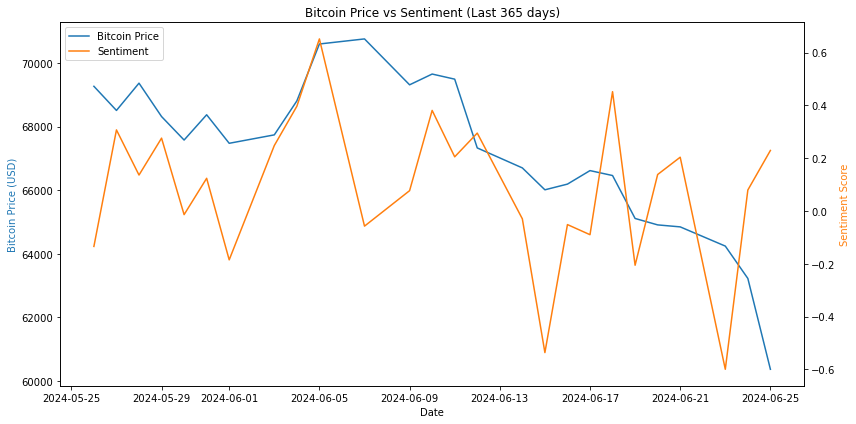

Correlation between Bitcoin price and sentiment: 0.30


In [20]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_bitcoin_data(days=180):
    end_date = datetime.now().strftime('%d-%m-%Y')
    start_date = (datetime.now() - timedelta(days=days)).strftime('%d-%m-%Y')
    
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"
    
    params = {
        'vs_currency': 'usd',
        'from': int(datetime.strptime(start_date, '%d-%m-%Y').timestamp()),
        'to': int(datetime.strptime(end_date, '%d-%m-%Y').timestamp())
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['prices'], columns=['Timestamp', 'Price'])
        df['Date'] = pd.to_datetime(df['Timestamp'], unit='ms').dt.date
        df = df.groupby('Date')['Price'].last().reset_index()
        return df
    else:
        print(f"Error fetching data: {response.status_code}")
        return None

def plot_bitcoin_sentiment(btc_df, days=180):
    bitcoin_prices = get_bitcoin_data(days)
    if bitcoin_prices is None:
        return
    
    btc_df['Date'] = pd.to_datetime(btc_df['Date']).dt.date
    daily_sentiment = btc_df.groupby('Date')['Compound'].mean().reset_index()
    
    start_date = max(bitcoin_prices['Date'].min(), daily_sentiment['Date'].min())
    end_date = min(bitcoin_prices['Date'].max(), daily_sentiment['Date'].max())
    
    bitcoin_prices = bitcoin_prices[(bitcoin_prices['Date'] >= start_date) & (bitcoin_prices['Date'] <= end_date)]
    daily_sentiment = daily_sentiment[(daily_sentiment['Date'] >= start_date) & (daily_sentiment['Date'] <= end_date)]
    
    merged_data = pd.merge(bitcoin_prices, daily_sentiment, on='Date', how='inner')
    
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Bitcoin Price (USD)', color='tab:blue')
    line1 = ax1.plot(merged_data['Date'], merged_data['Price'], color='tab:blue', label='Bitcoin Price')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Sentiment Score', color='tab:orange')
    line2 = ax2.plot(merged_data['Date'], merged_data['Compound'], color='tab:orange', label='Sentiment')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    plt.title(f'Bitcoin Price vs Sentiment (Last {days} days)')
    plt.tight_layout()
    plt.show()
    
    correlation = merged_data['Price'].corr(merged_data['Compound'])
    print(f"Correlation between Bitcoin price and sentiment: {correlation:.2f}")

# Example usage:
# Assuming btc_df is your sentiment DataFrame
plot_bitcoin_sentiment(btc_df, days=365)  # For 1 years (max limit)

---